In [ ]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [ ]:
# Trabajamos en colab:
from google.colab import drive
drive.mount('/content/drive/')

import os
path = '/content/drive/MyDrive/Colab Notebooks/LessonGH/'
os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import gamma, norm
import calendar
from scipy import stats as st

In [ ]:
pp_data = xr.open_dataset(path + 'DataGH/pp_monthly.nc', decode_times=False)
pp_data= pp_data.rename({"T":"time","Y":"lat","X":"lon"})
pp_data['time'] = pd.date_range('1981-01-01', '2016-12-31', freq = 'M')
pp_data = pp_data.sortby('lat')
pp_data

<xarray.Dataset>
Dimensions:  (time: 432, lat: 198, lon: 133)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2016-12-31
  * lat      (lat) float32 -18.75 -18.65 -18.55 -18.45 ... 0.65 0.75 0.85 0.95
  * lon      (lon) float32 -81.25 -81.15 -81.05 -80.95 ... -68.25 -68.15 -68.05
Data variables:
    Prec     (time, lat, lon) float32 ...

In [ ]:
pp_suda = pp_data['Prec']

In [ ]:
def spi_nc(ds, spi_type, dimension):

    # Media Movil
    ds_mm = ds.rolling({dimension: spi_type}, center=False).mean()

    # Logaritmo Natural con manejo de infinitos
    Ln_ds = np.log(ds_mm).where(~np.isinf(np.log(ds_mm)))

    # Promedio multi anual (promedio de las medias móviles)
    prom_ds = ds_mm.mean(dimension)

    # Summation of Natural log of moving averages
    Sum_Ln_ds = Ln_ds.sum(dimension)

    # Parámetros de la distribución Gamma
    n = Ln_ds.isel({dimension: slice(spi_type-1, None)}).count(dimension)
    A = np.log(prom_ds) - (Sum_Ln_ds / n)
    a = (1 / (4 * A)) * (1 + np.sqrt(1 + (4 * A) / 3))
    b = prom_ds / a
    t = len(Ln_ds[dimension])
    q = (t - n) / t

    # Distribución Gamma (CDF)
    gamma_cdf = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_cdf, ds_mm, a, b)

    # Aplicar corrección de frecuencia
    gamma_corrected = q + (1 - q) * gamma

    # Standardized Precipitation Index (SPI)
    norm_inv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    SPI = xr.apply_ufunc(norm_inv, gamma_corrected)
    return SPI

In [ ]:
spi_type =[1, 3, 6, 12]
for i in spi_type:
  pp_data[f'spi_{i}'] = spi_nc(pp_suda,i,'time')

In [ ]:
pp_data

<xarray.Dataset>
Dimensions:  (time: 432, lat: 198, lon: 133)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2016-12-31
  * lat      (lat) float32 -18.75 -18.65 -18.55 -18.45 ... 0.65 0.75 0.85 0.95
  * lon      (lon) float32 -81.25 -81.15 -81.05 -80.95 ... -68.25 -68.15 -68.05
Data variables:
    Prec     (time, lat, lon) float32 nan nan nan nan ... 242.4 384.4 498.1
    spi_1    (lat, lon, time) float64 nan nan nan nan ... -0.2174 -0.7916 1.631
    spi_3    (lat, lon, time) float64 nan nan nan nan ... -1.568 -1.351 0.4722
    spi_6    (lat, lon, time) float64 nan nan nan nan ... -1.524 -1.843 -0.6897
    spi_12   (lat, lon, time) float64 nan nan nan nan ... -1.107 -1.262 -0.9721

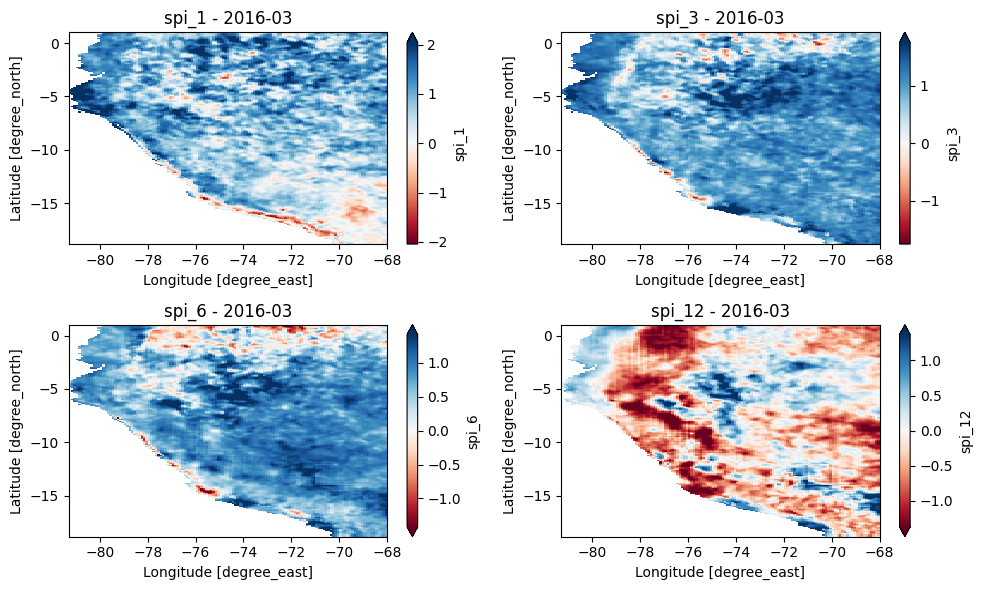

In [269]:
year = '2016-03'
spi_vars = ['spi_1', 'spi_3', 'spi_6', 'spi_12']
# Para cada variable SPI
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axes = axes.flatten()
for i, spi_var in enumerate(spi_vars):
    pp_data[spi_var].sel(time=year).plot(ax=axes[i], cmap='RdBu', robust=True)
    axes[i].set_title(f'{spi_var} - {year}')

plt.tight_layout()
plt.show()